# **Initialisation**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

data = pd.read_csv("/kaggle/input/walmart-dataset/Walmart.csv") #Import Walmart CSV Dataset 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Data Collection and Exploration**

In [2]:
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [4]:
numericalData = data.select_dtypes(include = ['float64', 'int64']).columns
print(f"\nNumerical Features:\n{numericalData}")

categoricalData = data.select_dtypes(include = ['object']).columns
print(f"\nCategorical Features:\n{categoricalData}")


Numerical Features:
Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')

Categorical Features:
Index(['Date'], dtype='object')


In [5]:
def seasonName(quarter):
    seasonMapping = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
    return seasonMapping.get(quarter, 'Unknown')
    
data['Date'] = pd.to_datetime(data['Date'], format = "%d-%m-%Y")
data['Week'] = data['Date'].dt.isocalendar().week.astype('int32')
data['Month_Name'] = data['Date'].dt.month_name()
data['Quarter'] = data['Date'].dt.quarter
data['Season'] = data['Quarter'].map(seasonName)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

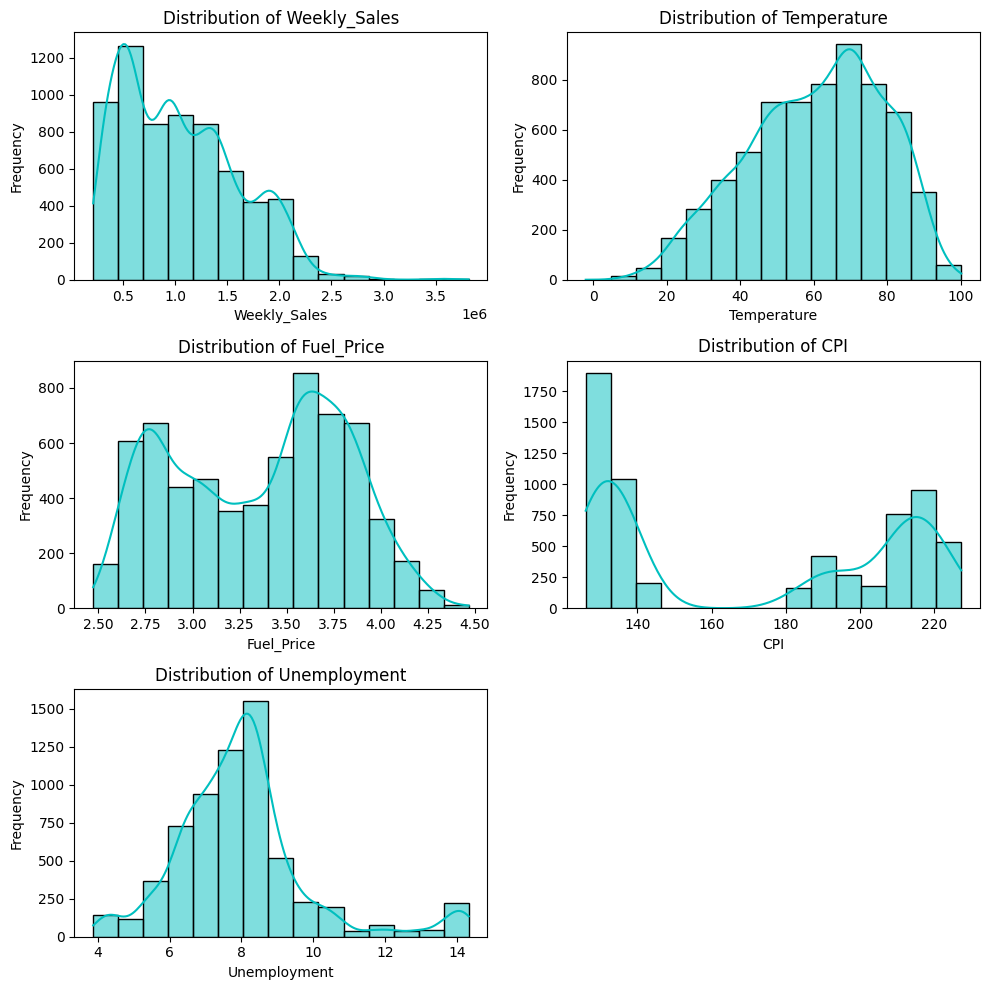

In [6]:
numericalData = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

plt.figure(figsize=(10, 10))

for i in numericalData:
    plt.subplot(3, 2, numericalData.index(i) + 1)
    sns.histplot(data = data, x = i, kde = True, bins = 15, color = 'c')
    plt.title(f"Distribution of {i}")
    plt.xlabel(i)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

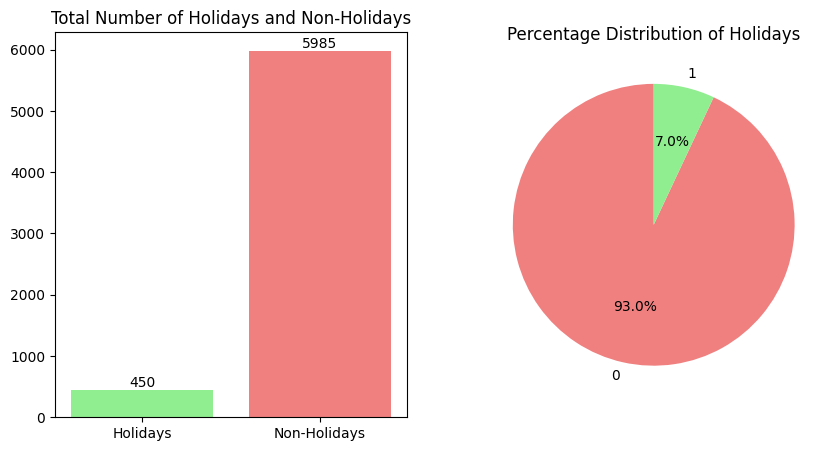

In [7]:
holidayFlagCounts = data['Holiday_Flag'].value_counts()

totalHolidays = holidayFlagCounts.get(1, 0)
totalNonHolidays = holidayFlagCounts.get(0, 0)

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
bars = plt.bar(['Holidays', 'Non-Holidays'], [totalHolidays, totalNonHolidays], color = ['lightgreen', 'lightcoral'])
plt.title("Total Number of Holidays and Non-Holidays")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha = 'center', va = 'bottom')

plt.subplot(1, 2, 2)
plt.pie(holidayFlagCounts, labels = holidayFlagCounts.index, autopct = '%1.1f%%', startangle = 90, colors = ['lightcoral', 'lightgreen'])
plt.title("Percentage Distribution of Holidays")

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


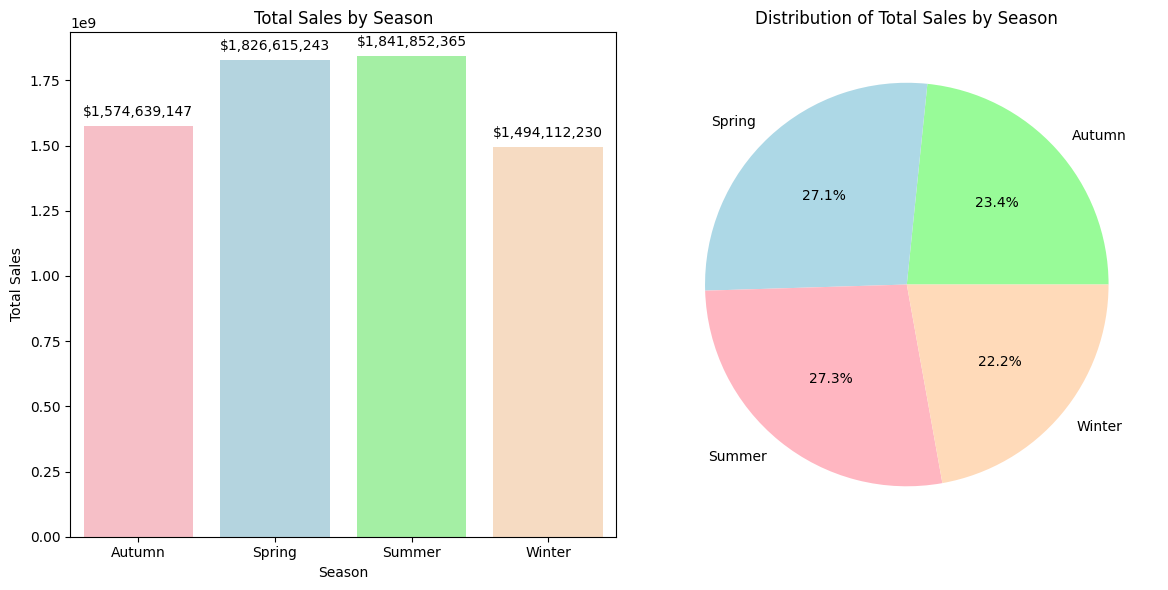

In [8]:
seasonCounts = data['Season'].value_counts()
seasonOrder = ['Winter', 'Spring', 'Summer', 'Autumn']

totalSalesBySeason = data.groupby('Season')['Weekly_Sales'].sum().sort_index()

plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
ax = sns.barplot(x = totalSalesBySeason.index, y = totalSalesBySeason.values, palette = ['#FFB6C1', '#ADD8E6', '#98FB98', '#FFDAB9'])
for p in ax.patches:
    ax.annotate(f'${int(p.get_height()):,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xlabel('Season')
plt.ylabel('Total Sales')
plt.title('Total Sales by Season')

plt.subplot(1, 2, 2)
plt.pie(totalSalesBySeason, labels = totalSalesBySeason.index, autopct = '%1.1f%%', colors = ['#98FB98', '#ADD8E6', '#FFB6C1', '#FFDAB9'])
plt.title('Distribution of Total Sales by Season')

plt.tight_layout()
plt.show()

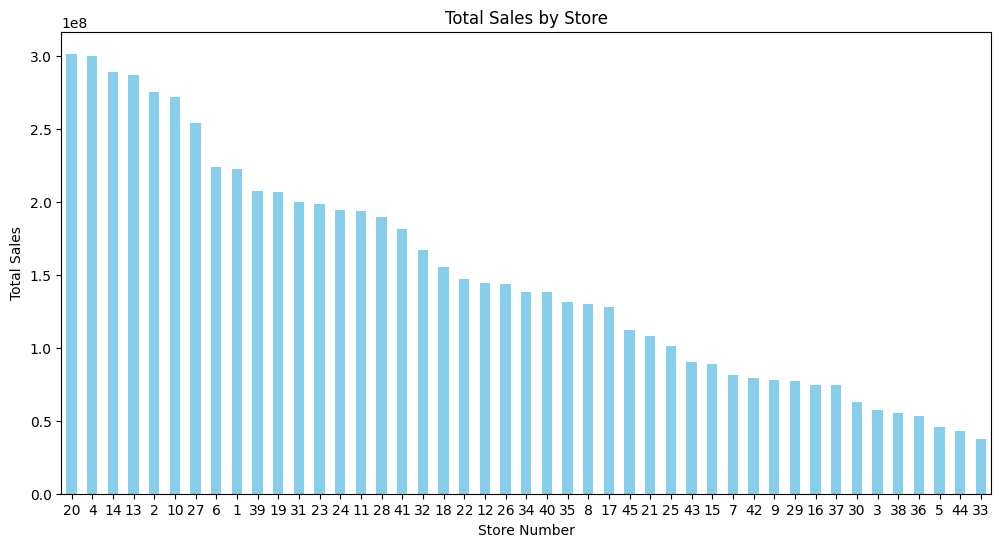

Highest Sales Store: 20, Total Sales: $301,397,792
Lowest Sales Store : 33, Total Sales: $37,160,222


In [9]:
totalSalesByStore = data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending = False)

plt.figure(figsize = (12, 6))
totalSalesByStore.plot(kind = 'bar', color = 'skyblue')

plt.title('Total Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.show()

highestSalesStore = totalSalesByStore.idxmax()
highestSalesValue = totalSalesByStore.max()
print(f"Highest Sales Store: {highestSalesStore}, Total Sales: ${highestSalesValue:,.0f}")

lowestSalesStore = totalSalesByStore.idxmin()
lowestSalesValue = totalSalesByStore.min()
print(f"Lowest Sales Store : {lowestSalesStore}, Total Sales: ${lowestSalesValue:,.0f}")

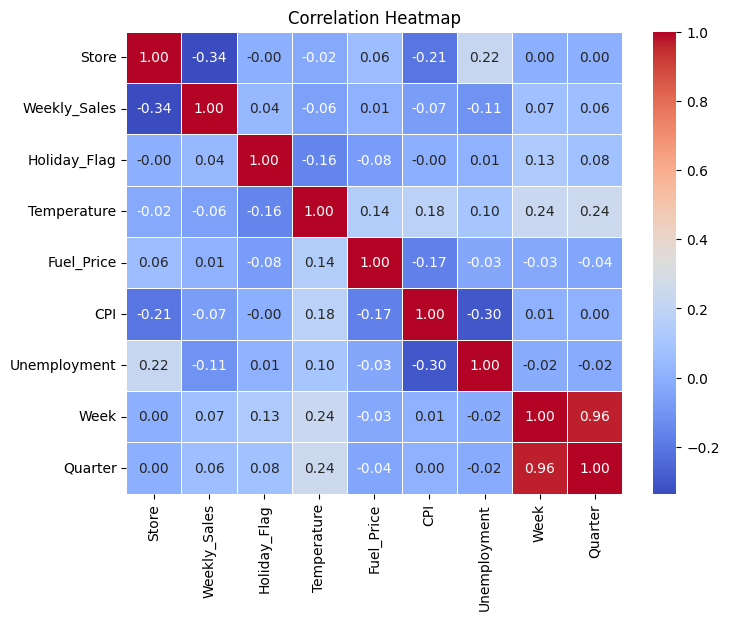

In [10]:
correlationMap = data.select_dtypes(include = ['number']).corr()

plt.figure(figsize = (8, 6))
sns.heatmap(correlationMap, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidths = .5)
plt.title('Correlation Heatmap')
plt.show()

# **Data Preprocessing**

In [11]:
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Week            0
Month_Name      0
Quarter         0
Season          0
dtype: int64

In [12]:
data.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
Week                     int32
Month_Name              object
Quarter                  int32
Season                  object
dtype: object

In [13]:
dataPreprocess = data.copy()
dataPreprocess.drop(['Date', 'Quarter'], axis = 1, inplace = True)

dataPreprocess.dtypes

Store             int64
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Week              int32
Month_Name       object
Season           object
dtype: object

In [14]:
dataPreprocess['Store'] = dataPreprocess['Store'].astype('object')
dataPreprocess['Holiday_Flag'] = dataPreprocess['Holiday_Flag'].astype('object')
dataPreprocess['Week'] = dataPreprocess['Week'].astype('object')

dataPreprocess.dtypes

Store            object
Weekly_Sales    float64
Holiday_Flag     object
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Week             object
Month_Name       object
Season           object
dtype: object

In [15]:
X = dataPreprocess.drop('Weekly_Sales', axis = 1)
y = dataPreprocess['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

numericalFeatures = dataPreprocess.select_dtypes('number').columns.to_list()
numericalFeatures.remove('Weekly_Sales')

categoricalFeatures = dataPreprocess.select_dtypes('object').columns.to_list()

print(f"Numerical Features  : {numericalFeatures}")
print(f"Categorical Features: {categoricalFeatures}")

Numerical Features  : ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
Categorical Features: ['Store', 'Holiday_Flag', 'Week', 'Month_Name', 'Season']


In [16]:
preprocessor = ColumnTransformer([('num_features', StandardScaler(), numericalFeatures),
                                  ('cat_features', BinaryEncoder(), categoricalFeatures),])

preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

# **Model Building and Evaluation**

In [17]:
#Calculating the evaluation metrics of the decision tree
def evaluateModel(model, X, y_test):
    
    y_predict = model.predict(X)
    
    MAE = mean_absolute_error(y_test, y_predict)
    MSE = mean_squared_error(y_test, y_predict)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test, y_predict)

    print(f"Mean Absolute Error    : {MAE}")
    print(f"Mean Squared Error     : {MSE}")
    print(f"Root Mean Squared Error: {RMSE}")
    print(f"\nR2 Score: {R2}")

## **1. Decision Tree Regressor** 

In [18]:
decisionTree_regressor = DecisionTreeRegressor()
decisionTree_regressor.fit(X_train_transformed, y_train)

print("\nEvaluation for Decision Tree Regressor Model\n")
evaluateModel(decisionTree_regressor, X_train_transformed, y_train)


Evaluation for Decision Tree Regressor Model

Mean Absolute Error    : 0.0
Mean Squared Error     : 0.0
Root Mean Squared Error: 0.0

R2 Score: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

## **2. Random Forest Regressor** 

In [19]:
randomForest_regressor = RandomForestRegressor()
randomForest_regressor.fit(X_train_transformed, y_train)

print("\nEvaluation for Random Forest Regressor Model\n")
evaluateModel(randomForest_regressor, X_train_transformed, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):



Evaluation for Random Forest Regressor Model

Mean Absolute Error    : 25476.60743714065
Mean Squared Error     : 2344807925.2805996
Root Mean Squared Error: 48423.216800214745

R2 Score: 0.9926151786930142


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

## **3. XGB Regressor** 

In [20]:
XGB_regressor = XGBRegressor()
XGB_regressor.fit(X_train_transformed, y_train)

print("\nEvaluation for XGB Regressor Model\n")
evaluateModel(XGB_regressor, X_train_transformed, y_train)


Evaluation for XGB Regressor Model

Mean Absolute Error    : 25935.83068728147
Mean Squared Error     : 1365843824.1815712
Root Mean Squared Error: 36957.32436448249

R2 Score: 0.9956983629805738


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

# **Hyperparameter Tuning**

In [21]:
#Tuning the model to optimise the performance
def tuneModel(model, X_train, y_train, param_grid, scoring = 'r2', cv=5):   
    
    grid_search = GridSearchCV(estimator = model,
                               param_grid = param_grid,
                               scoring = 'r2',
                               cv = cv)
    
    grid_search.fit(X_train, y_train)

    bestParamaters = grid_search.best_params_
    bestScore = grid_search.best_score_

    print(f"Best parameters: {bestParamaters} \n")
    print(f"Best R2 score  : {bestScore}")
    
    bestModel = grid_search.best_estimator_
    return bestModel

In [22]:
#Perform cross validation score for the regressor
def crossValidScore(model, X_train, y_train, scoring = 'r2', cv = 5):
    
    result = cross_val_score(model, X_train, y_train, scoring = scoring, cv = cv)

    print(f"\nCross Validation Scores ({scoring}): {result}")
    print(f"Mean Squared Error: {result.mean() * 100:.2f}%")
    print(f"Standard Deviation: {result.std()}")

## **1. Decision Tree Regressor** 

In [23]:
dt_param_grid = {'max_depth': np.arange(2, 15),
              'min_samples_split': [10, 20, 30, 40, 50, 100, 200, 300]}

decisionTree_regressor_tuned = tuneModel(decisionTree_regressor, X_train_transformed, y_train, dt_param_grid, 'r2', cv = 5)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

Best parameters: {'max_depth': 10, 'min_samples_split': 40} 

Best R2 score  : 0.9202103606051721


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [24]:
print("\nEvaluation for tuned Decision Tree Regressor Model\n")
evaluateModel(decisionTree_regressor_tuned, X_train_transformed, y_train)
crossValidScore(decisionTree_regressor_tuned, X_train_transformed, y_train, 'r2', 5)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp


Evaluation for tuned Decision Tree Regressor Model

Mean Absolute Error    : 68069.72679791895
Mean Squared Error     : 15633366726.805437
Root Mean Squared Error: 125033.46242828532

R2 Score: 0.9507637199365829

Cross Validation Scores (r2): [0.91989913 0.91777492 0.92235514 0.90888256 0.9298497 ]
Mean Squared Error: 91.98%
Standard Deviation: 0.006794336360307715


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [25]:
print("\nTesting the tuned Decision Tree Regressor Model\n")
evaluateModel(decisionTree_regressor_tuned, X_test_transformed, y_test)


Testing the tuned Decision Tree Regressor Model

Mean Absolute Error    : 84427.83568096609
Mean Squared Error     : 25196077759.132633
Root Mean Squared Error: 158732.72428561363

R2 Score: 0.9217888537827215


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

## **2. Random Forest Regressor** 

In [26]:
#No hyperparameter tuning for Random Forest Regressor
crossValidScore(randomForest_regressor, X_train_transformed, y_train, 'r2', 5)
print("\nTesting the Random Forest Regressor Model\n")
evaluateModel(randomForest_regressor, X_test_transformed, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp


Cross Validation Scores (r2): [0.93673801 0.94457316 0.94377027 0.93209876 0.95409946]
Mean Squared Error: 94.23%
Standard Deviation: 0.007503966232685261

Testing the Random Forest Regressor Model

Mean Absolute Error    : 70806.86360971253
Mean Squared Error     : 17467635520.25966
Root Mean Squared Error: 132165.18270807806

R2 Score: 0.9457787117183358


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

## **3. XGB Regressor** 

In [27]:
xgb_param_grid = {'learning_rate': [0.01, 0.1],
                  'max_depth': [3, 5, 7, 10],
                  'min_child_weight': [1, 3, 5],
                  'subsample': [0.5, 0.7],
                  'colsample_bytree': [0.5, 0.7],
                  'n_estimators' : [100, 200, 500],
                  'objective': ['reg:squarederror']}

XGB_regressor_tuned = tuneModel(XGB_regressor, X_train_transformed, y_train, xgb_param_grid, 'r2', cv = 5)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.7} 

Best R2 score  : 0.9684835732207764


In [28]:
print("\nEvaluation for tuned XGB Regressor Model\n")
evaluateModel(XGB_regressor_tuned, X_train_transformed, y_train)
crossValidScore(XGB_regressor_tuned, X_train_transformed, y_train, 'r2', 5)


Evaluation for tuned XGB Regressor Model

Mean Absolute Error    : 14202.296021148992
Mean Squared Error     : 419404221.44265276
Root Mean Squared Error: 20479.36086509178

R2 Score: 0.9986791134585666


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp


Cross Validation Scores (r2): [0.96502974 0.96853246 0.96921109 0.9673448  0.97229978]
Mean Squared Error: 96.85%
Standard Deviation: 0.002379952462877128


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [29]:
print("\nTesting the tuned XGB Regressor Model\n")
evaluateModel(XGB_regressor_tuned, X_test_transformed, y_test)


Testing the tuned XGB Regressor Model

Mean Absolute Error    : 58071.7125228851
Mean Squared Error     : 9027246009.140652
Root Mean Squared Error: 95011.8203653664

R2 Score: 0.9719785252169126


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp